<a href="https://colab.research.google.com/drive/1tx5iDzZix9Wi2Ma1xTXYkUJ1fY8gwcIU#scrollTo=esOiLvqPMb2E">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
!git clone https://github.com/Fonsydo/Proyecto_IA.git

Cloning into 'Proyecto_IA'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 73 (delta 23), reused 37 (delta 9), pack-reused 0
Unpacking objects: 100% (73/73), 2.86 MiB | 5.14 MiB/s, done.
Filtering content: 100% (7/7), 900.04 MiB | 30.98 MiB/s, done.


# Inteligencia Artificial para las Ciencias e Ingenierías
## Proyecto Sistema de Recomendación de Películas
### Miembros del grupo
* Fonsy Johan Mercado Agudelo, CC 1020472932, Ingeniería eléctrica
* Orlando José Salazar Polo, CC 1152714311, Ingeniería eléctrica
* Angie Dayana Rincón Mandón, CC 1091681348, Ingeniería eléctrica

### Exploración de datos


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import linear_model
from wordcloud import WordCloud

### The movies dataset
Para el desarrollo de este proyecto se seleccionó el dataset [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) proporcionado en kaggle, estos archivos contienen metadatos de 45.000 películas enumeradas en el conjunto de datos completo de MovieLens. Este conjunto de datos también tiene archivos que contienen 26 millones de calificaciones de 270.000 usuarios para las 45.000 películas. Las calificaciones están en una escala de 1 a 5 y se han obtenido del sitio web oficial de GroupLens.

El dataset tiene un total de 900 MB y contiene los siguientes archivos .csv

- **movies_metadata.csv**: Archivo principal de metadatos de películas, contiene información de 45000 películas incluyendo carteles, fondos, presupuesto, ingresos, fechas de lanzamiento, idiomas, países de producción y empresas.

- **keywords.csv**: Contiene las palabras clave de la trama de la película en forma de un objeto JSON en cadena.

- **credits.csv**: Contiene información sobre el reparto y equipo técnico de las películas en forma de objeto JSON en cadena.

- **links.csv**: Contiene los ID de TMDB e IMDB de las películas que aparecen en el conjunto de datos de MovieLens.

- **links_small.csv**: Contiene los ID de TMDB e IMDB de un subconjunto de 9.000 películas del conjunto de datos completo.

- **ratings_small.csv** El subconjunto de 100.000 calificaciones de 700 usuarios en 9.000 películas

In [65]:
credits = pd.read_csv('/content/Proyecto_IA/the-movies-dataset/credits.csv')
keywords = pd.read_csv('/content/Proyecto_IA/the-movies-dataset/keywords.csv')
movies = pd.read_csv('/content/Proyecto_IA/the-movies-dataset/movies_metadata.csv', low_memory=False).\
                        drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1)

movies['id'] = movies['id'].apply(pd.to_numeric, errors='coerce')
movies.dropna(inplace=True)
movies['id'] = movies['id'].astype('int64')

df = movies.merge(keywords, on='id'). merge(credits, on='id')

df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

In [ ]:
df.sample(2)

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,cast,crew
15843,False,0,"[{'id': 27, 'name': 'Horror'}]",30997,en,La casa 3,A group of unlikely companions receive a radio...,2.739535,"[{'name': 'Filmirage', 'id': 6082}]","[{'iso_3166_1': 'IT', 'name': 'Italy'}]",1988-05-21,0.0,95.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",We dare you to go inside...,4.5,22.0,"[{'id': 3358, 'name': 'haunted house'}, {'id':...","[{'cast_id': 5, 'character': 'Martha', 'credit...","[{'credit_id': '52fe44539251416c9100cbb1', 'de..."
8656,False,0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 878, 'n...",27361,fr,Black Moon,There is a war in the world between the men an...,9.2161,"[{'name': 'Bioskop-Film GmbH', 'id': 403}, {'n...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",1975-09-24,0.0,100.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",An apocalyptic Alice in Wonderland!,6.8,39.0,"[{'id': 572, 'name': 'sex'}, {'id': 1501, 'nam...","[{'cast_id': 4, 'character': 'Lily', 'credit_i...","[{'credit_id': '52fe4544c3a368484e0506c7', 'de..."


In [ ]:
def get_text(text, obj='name'):
    text = eval(text)
    
    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)
    
df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)

df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)

df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

df.drop('cast', axis=1, inplace=True)
df = df[~df['original_title'].duplicated()]
df = df.reset_index(drop=True)

In [ ]:
df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,False,65000000.0,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,...,262797249.0,104.0,"English, Français",Roll the dice and unleash the excitement!,6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
1,False,0.0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,"Warner Bros., Lancaster Gate",United States of America,...,0.0,101.0,English,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
2,False,16000000.0,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,...,81452156.0,127.0,English,Friends are the people who let you be yourself...,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
3,False,0.0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,...,76578911.0,106.0,English,Just When His World Is Back To Normal... He's ...,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."
4,False,60000000.0,"Action, Crime, Drama, Thriller",949,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",17.924927,"Regency Enterprises, Forward Pass, Warner Bros.",United States of America,...,187436818.0,170.0,"English, Español",A Los Angeles Crime Saga,7.7,1886.0,"robbery, detective, bank, obsession, chase, sh...","Michael Mann, Michael Mann, Art Linson, Michae...","Lt. Vincent Hanna, Neil McCauley, Chris Shiher...","Al Pacino, Robert De Niro, Val Kilmer, Jon Voi..."


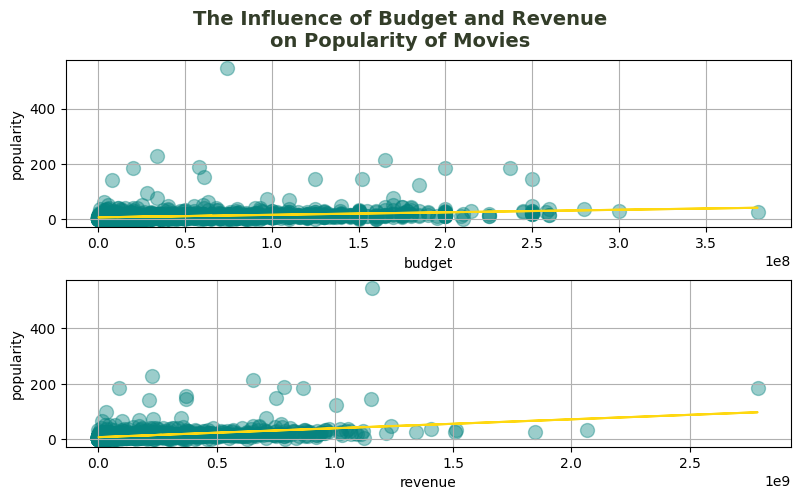

In [ ]:
df_plot = df[(df['revenue']!=0) & (df['budget']!=0)]

regr = linear_model.LinearRegression()

plt.figure(figsize=(8,5))
plt.suptitle('The Influence of Budget and Revenue\non Popularity of Movies', fontsize=14, weight=600, color='#333d29')

for i, col in enumerate(['budget', 'revenue']):
    regr.fit(np.array(df_plot[col]).reshape(-1,1), df_plot['popularity'].values)
    plt.subplot(2,1,i+1)
    plt.grid()
    plt.scatter(df_plot[col], df_plot['popularity'], alpha=.4, s=100, color='#06837f')
    plt.plot(df_plot[col], df_plot[col]*regr.coef_[0]+regr.intercept_, color='#fed811')
    plt.xlabel(col)
    plt.ylabel('popularity')
plt.tight_layout(pad=0.7);

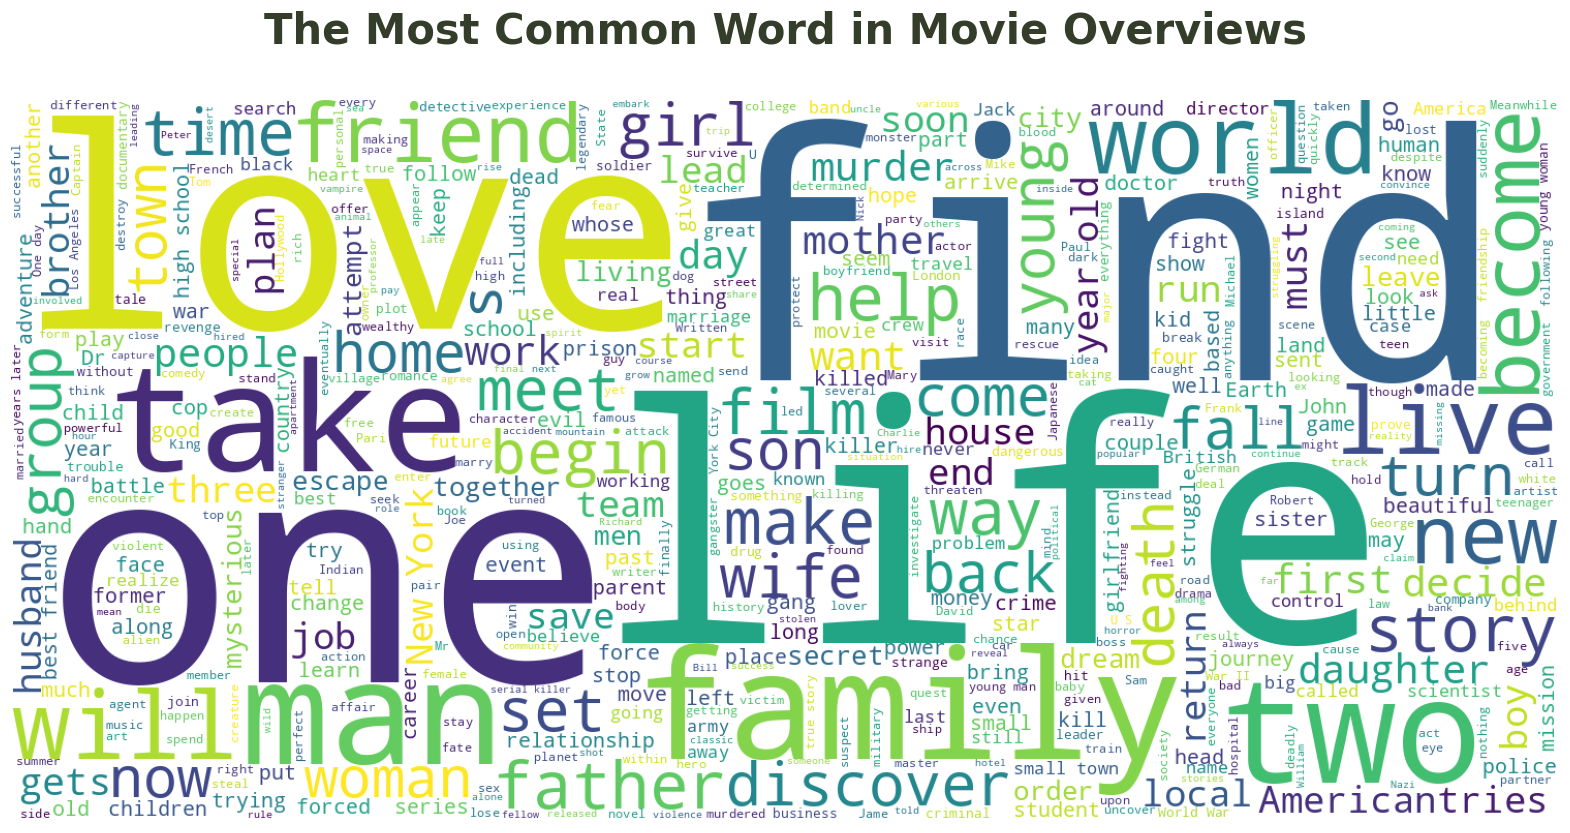

In [ ]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30, weight=600, color='#333d29')
wc = WordCloud(max_words=1000, min_font_size=10,
                height=700,width=1500,background_color="white").generate(' '.join(df['overview']))
plt.axis('off')
plt.imshow(wc)

(-1.25, 1.25, -1.25, 1.25)

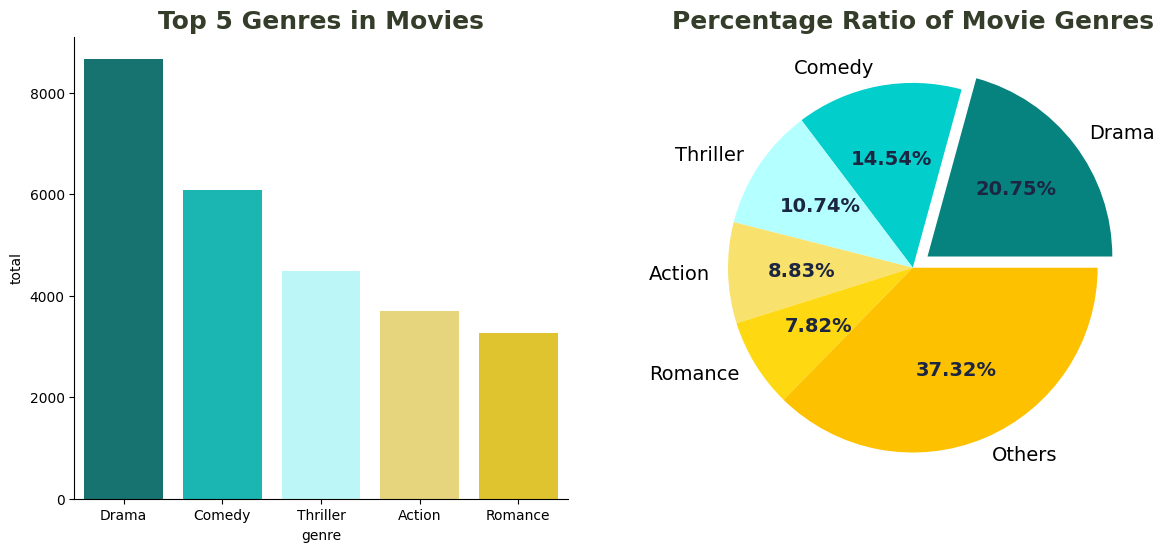

In [ ]:
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0.1,0,0,0,0,0], colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')

Text(0.5, 1.0, 'Total Released Movie by Date')

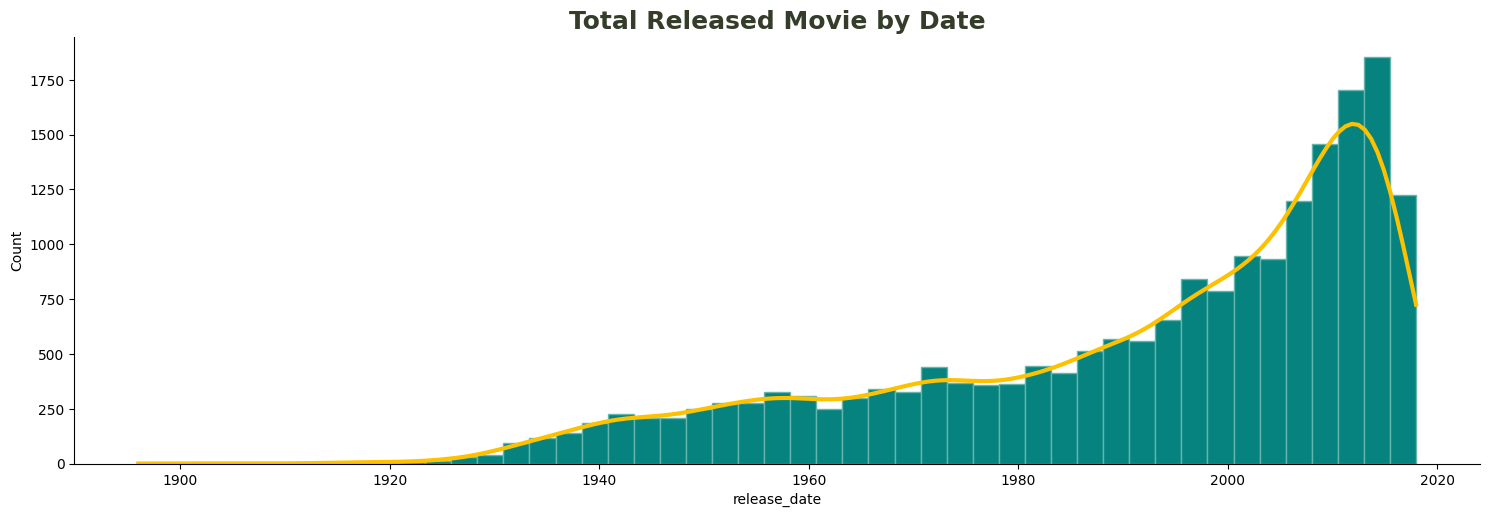

In [ ]:
sns.displot(data=df, x='release_date', kind='hist', kde=True,
            color='#fdc100', facecolor='#06837f', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3)
plt.title('Total Released Movie by Date', fontsize=18, weight=600, color='#333d29')

Text(0.5, 1.0, 'The Relationship Between Rating and Popularity')

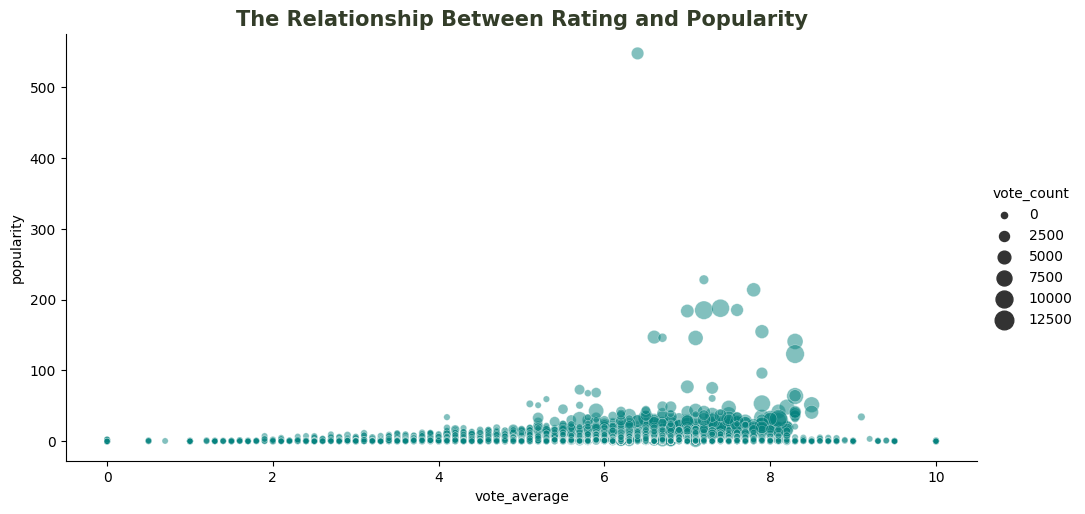

In [ ]:
sns.relplot(data=df, x='vote_average', y='popularity', size='vote_count',
            sizes=(20, 200), alpha=.5, aspect=2, color='#06837f')
plt.title('The Relationship Between Rating and Popularity', fontsize=15, weight=600, color='#333d29')

<ipython-input-61-d48c5f2ab594>:8: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
<ipython-input-61-d48c5f2ab594>:8: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
<ipython-input-61-d48c5f2ab594>:8: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
<ipython-input-61-d48c5f2ab594>:8: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])


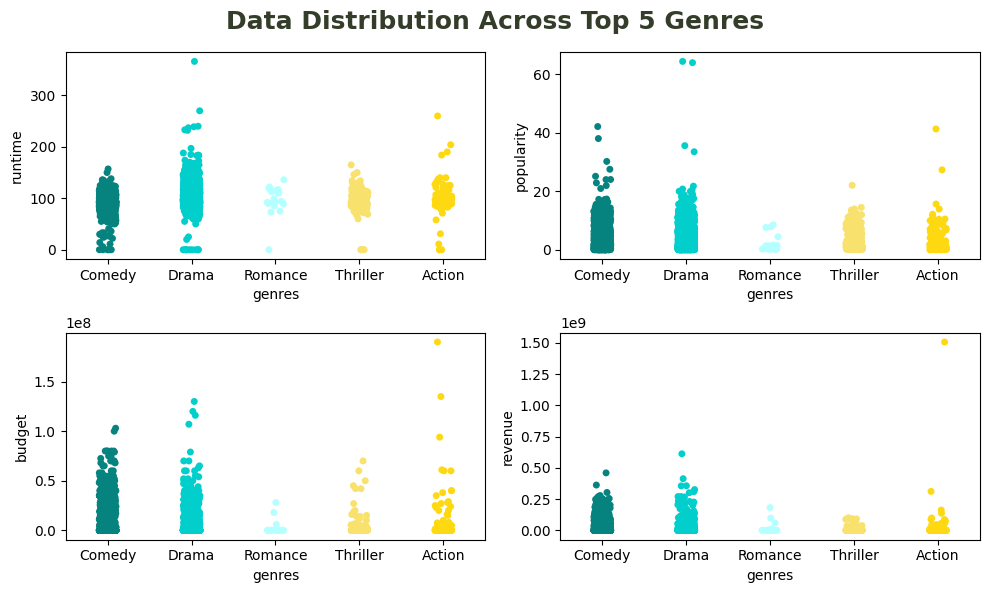

In [ ]:
df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
df_plot = df[df['genres'].isin(df_plot['genre'].to_numpy())]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

plt.suptitle('Data Distribution Across Top 5 Genres', fontsize=18, weight=600, color='#333d29')
for i, y in enumerate(['runtime', 'popularity', 'budget', 'revenue']):
    sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])

plt.tight_layout()

<ipython-input-62-82bdc4b1807e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap=['#004346', '#036666', '#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])


<Axes: title={'center': 'Correlation of Movie Features\n'}>

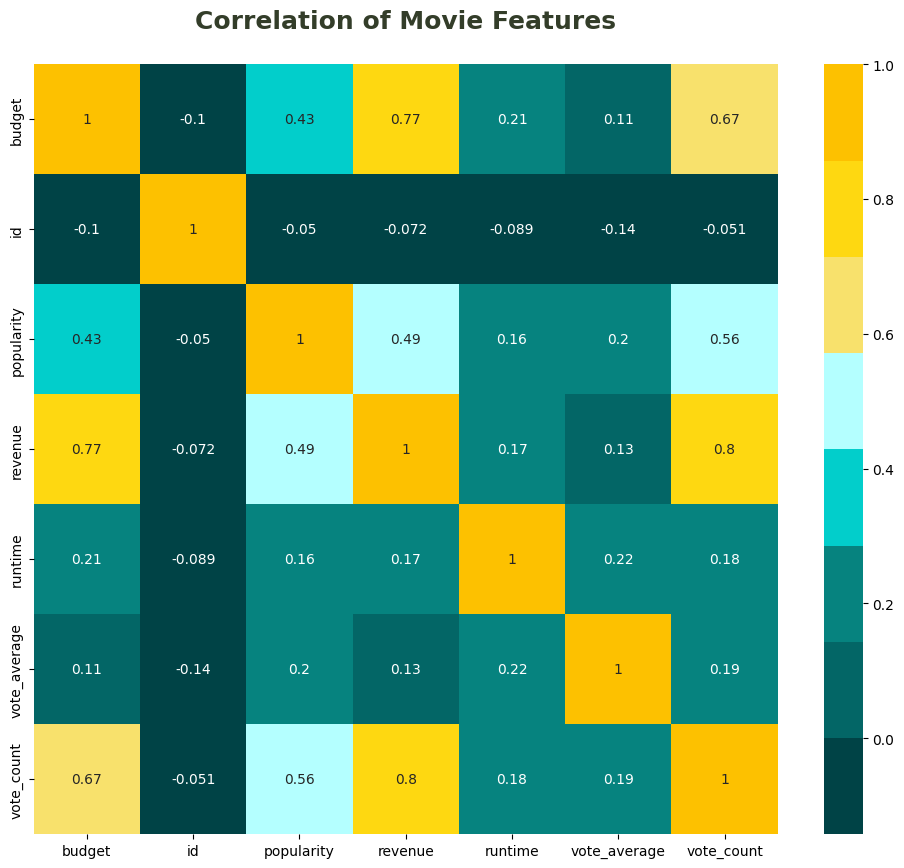

In [ ]:
plt.figure(figsize=(12,10))
plt.title('Correlation of Movie Features\n', fontsize=18, weight=600, color='#333d29')
sns.heatmap(df.corr(), annot=True, cmap=['#004346', '#036666', '#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])